In [7]:
import scipy
import torch
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append('../')
from src.data_generator import MRIDataset
from src.model import Unet
from src.losses.dice import dice_coefficient

In [94]:
data_path = '../data/all/'

t1_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_seg_*')))
t2_list[2]

'../data/all/VS-1-30/vs_gk_11/vs_gk_t2_refT2.nii.gz'

In [95]:
# clicks_dataset = MRIDataset(
#     t1_list[2:4], t2_list[2:4], seg_list[2:4],
#     (40, 80, 80),
#     clicks = {
#         'use': True,
#         'gen_fg': False,
#         'gen_bg': False,
#         'gen_border': True,
#         'num': 20,
#         'size': 1
#     }
# )

dataset = MRIDataset(
    t1_list, t2_list, seg_list,
    (40, 128, 128),
)

In [96]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    """ Returns the first and last slice indices of the tumour in given mask """
    
    glioma_indices = torch.nonzero((mask > 0))[:,1]
    # first = torch.nonzero((mask > 0))[:,1][0].item()
    # last = torch.nonzero((mask > 0))[:,1][-1].item()
    if len(glioma_indices) == 0:
        return 0, 0
    
    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last


In [142]:
model = Unet(
    in_channels=2, 
    out_channels=1, 
    blocks=3
).to('cpu')

checkpoint = torch.load('../models/clicks_checkpoint.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [ ]:
a = 0

for i in range(len(t1_list)):
    x, y = dataset[i]
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)

    y_pred = model(x)
    dice = dice_coefficient(y_pred, y).item()
    if dice < 0.2:
        print(i)
        print(dice)
        a += 1
    
    if a == 10:
        break

In [146]:
x, y = dataset[220]
x = x.unsqueeze(0)
y = y.unsqueeze(0)

y_pred = model(x)
dice = dice_coefficient(y_pred, y).item()
print(dice)

0.49367865920066833


20 32


Text(0.5, 1.0, 'Prediction')

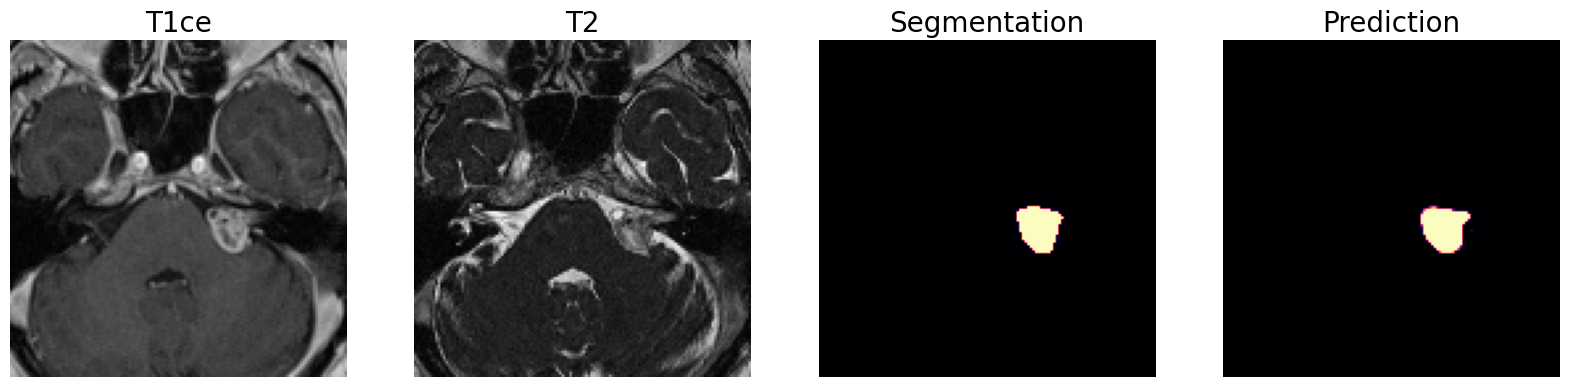

In [144]:
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
first, last = get_glioma_indices(y[0])
print(first, last)

slice = 25
axs[0].imshow(x[0,0,slice,:,:].rot90(3), cmap='gray')
axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[0,1,slice,:,:].rot90(3), cmap='gray')
axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,0,slice,:,:].rot90(3), cmap='magma')
axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)
axs[3].imshow(y_pred[0,0,slice,:,:].rot90(3).detach(), cmap='magma')
axs[3].axis('off')
axs[3].set_title('Prediction', fontsize=20)
# fig.suptitle(f'Dice: {dice:1f}', fontsize=20)